# 🚀 Hackathon - Jour 2 : Exploration de données

## 1. Collecte de données
### 📌 Objectif :
Importer les ensembles de données nécessaires (CSV) provenant de ce lien : https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents?resource=download
- C'est un jeu de données national sur les accidents de voiture couvrant 49 États des États-Unis.
- Les données d’accidents ont été collectées de février 2016 à mars 2023 grâce à plusieurs API fournissant des flux d’incidents (ou événements) de circulation.
- Ces API diffusent des données de trafic captées par différentes entités, notamment le département des transports des États-Unis et ceux des États fédérés, les forces de l’ordre, les caméras de surveillance du trafic et les capteurs routiers intégrés aux réseaux routiers.
- Le jeu de données contient actuellement environ 7,7 millions d’enregistrements d’accidents.

In [3]:
# Charger le dataset US Accidents
import pandas as pd
csv_path = "data/US_Accidents_March23.csv"
df = pd.read_csv(csv_path)
df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


## 2. Nettoyage des données
### 📌 Objectif :
Préparation et nettoyage du dataset d’accidents afin qu’il soit propre, cohérent et exploitable pour l’analyse ou le Machine Learning.

- Standardisation des colonnes
- Suppression des données invalides
- Gestion des valeurs manquantes
- Nettoyage des valeurs textuelles
- Filtrage des données aberrantes
- Casting des types

In [4]:
import re


def clean_column_name(name):
    cleaned = re.sub(r'[^0-9a-zA-Z_]', '_', name)
    cleaned = re.sub(r'_+', '_', cleaned)
    return cleaned.strip('_').lower()

# Nettoyer les noms de colonnes
df.columns = [clean_column_name(c) for c in df.columns]

# 1. Supprimer les lignes avec nulls critiques
critical_cols = ["id", "severity", "state", "start_lat", "start_lng", "start_time"]
df = df.dropna(subset=critical_cols)

# 2. Remplir end_lat/end_lng avec start_lat/start_lng si manquant
df["end_lat"] = df["end_lat"].fillna(df["start_lat"])
df["end_lng"] = df["end_lng"].fillna(df["start_lng"])

# 3. Remplacer valeurs manquantes par défauts
defaults = {
    'temperature_f': 70.0,
    'humidity': 60.0,
    'pressure_in': 29.92,
    'visibility_mi': 10.0,
    'wind_speed_mph': 5.0,
    'weather_condition': 'CLEAR',
    'wind_direction': 'CALM',
    'description': 'No description available',
    'street': 'Unknown Street',
    'zipcode': '00000',
    'timezone': 'US/Eastern',
    'airport_code': 'UNKNOWN',
    'sunrise_sunset': 'Day',
    'civil_twilight': 'Day',
    'nautical_twilight': 'Day',
    'astronomical_twilight': 'Day'
}
df = df.fillna(defaults)

# 4. Supprimer doublons
df = df.drop_duplicates(subset=["id"])

# 5. Normaliser textes
for col in ["state", "weather_condition", "wind_direction"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.upper()

# 6. Filtrer severité (1-4)
df = df[df["severity"].between(1, 4)]

# 7. Filtrer coordonnées (approx USA)
df = df[
    df["start_lat"].between(24.0, 50.0) &
    df["start_lng"].between(-130.0, -65.0)
]

df["severity"] = df["severity"].astype(int)
df["start_lat"] = df["start_lat"].astype(float)
df["start_lng"] = df["start_lng"].astype(float)
df["end_lat"] = df["end_lat"].astype(float)
df["end_lng"] = df["end_lng"].astype(float)
if "distance_mi" in df.columns:
    df["distance_mi"] = df["distance_mi"].astype(float)
df["temperature_f"] = df["temperature_f"].astype(float)
df["humidity"] = df["humidity"].astype(float)
df["pressure_in"] = df["pressure_in"].astype(float)
df["visibility_mi"] = df["visibility_mi"].astype(float)
df["wind_speed_mph"] = df["wind_speed_mph"].astype(float)

# Cast des booléens
boolean_cols = ['amenity', 'bump', 'crossing', 'give_way', 'junction', 
               'no_exit', 'railway', 'roundabout', 'station', 'stop', 
               'traffic_calming', 'traffic_signal', 'turning_loop']
for col in boolean_cols:
    if col in df.columns:
        df[col] = df[col].astype(bool)

# Cast des dates
for col in ["start_time", "end_time", "weather_timestamp"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

print(f" Nettoyage terminé : {len(df)} lignes restantes")

 Nettoyage terminé : 7728394 lignes restantes


## 3. Analyse exploratoire des données (EDA)
### 📌 Objectif :
Mener une première exploration statistique et visuelle du dataset pour mieux comprendre :
- La répartition des variables (ex. sévérité des accidents)
- Les statistiques descriptives globales
- Décrire les variables  
- Identifier les tendances et patterns  
- Explorer les relations entre variables

           severity                     start_time  \
count  7.728394e+06                        6985228   
mean   2.212384e+00  2020-03-21 21:49:59.056443136   
min    1.000000e+00            2016-01-14 20:18:33   
25%    2.000000e+00  2018-09-17 02:20:31.750000128   
50%    2.000000e+00     2020-06-23 13:37:23.500000   
75%    2.000000e+00            2021-10-28 15:44:07   
max    4.000000e+00            2023-03-31 23:30:00   
std    4.875313e-01                            NaN   

                            end_time     start_lat     start_lng  \
count                        6985228  7.728394e+06  7.728394e+06   
mean   2020-03-22 04:56:51.646936064  3.620119e+01 -9.470255e+01   
min              2016-02-08 06:37:08  2.455480e+01 -1.246238e+02   
25%       2018-09-17 05:23:37.500000  3.339963e+01 -1.172194e+02   
50%              2020-06-23 15:20:42  3.582397e+01 -8.776662e+01   
75%       2021-10-29 14:57:46.500000  4.008496e+01 -8.035368e+01   
max              2023-03-31 23:59:00 

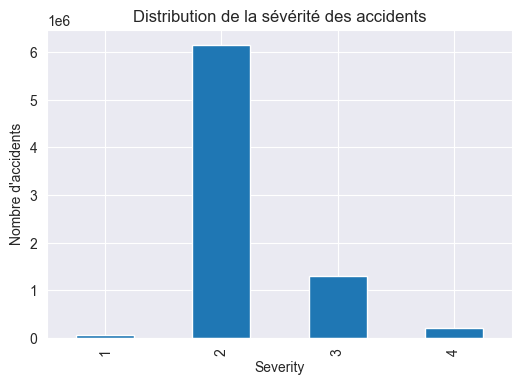

                  severity  start_lat  start_lng   end_lat   end_lng  \
severity          1.000000   0.069060   0.052862  0.069055  0.052860   
start_lat         0.069060   1.000000  -0.067720  0.999996 -0.067717   
start_lng         0.052862  -0.067720   1.000000 -0.067715  0.999999   
end_lat           0.069055   0.999996  -0.067715  1.000000 -0.067713   
end_lng           0.052860  -0.067717   0.999999 -0.067713  1.000000   
distance_mi       0.034787   0.064064   0.007851  0.064099  0.007858   
temperature_f    -0.019651  -0.439336  -0.011264 -0.439333 -0.011262   
wind_chill_f     -0.070039  -0.480296  -0.031810 -0.480292 -0.031807   
humidity          0.021825   0.022082   0.177483  0.022075  0.177476   
pressure_in       0.042191  -0.192005   0.190554 -0.192002  0.190556   
visibility_mi    -0.002804  -0.086470  -0.014577 -0.086473 -0.014575   
wind_speed_mph    0.028474   0.029998   0.077737  0.030007  0.077743   
precipitation_in  0.021080   0.000279   0.027619  0.000278  0.02

In [5]:
# Statistiques descriptives
print(df.describe())

# Distribution de la variable Severity
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
df['severity'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution de la sévérité des accidents')
plt.xlabel('Severity')
plt.ylabel('Nombre d\'accidents')
plt.show()

# Corrélation entre variables numériques
numeric_df = df.select_dtypes(include=['number'])
corr = numeric_df.corr()
print(corr)


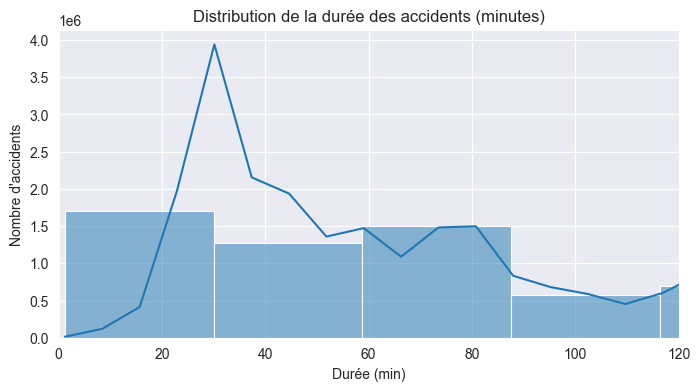

Durée moyenne: 105.95 minutes
Durée médiane: 62.15 minutes


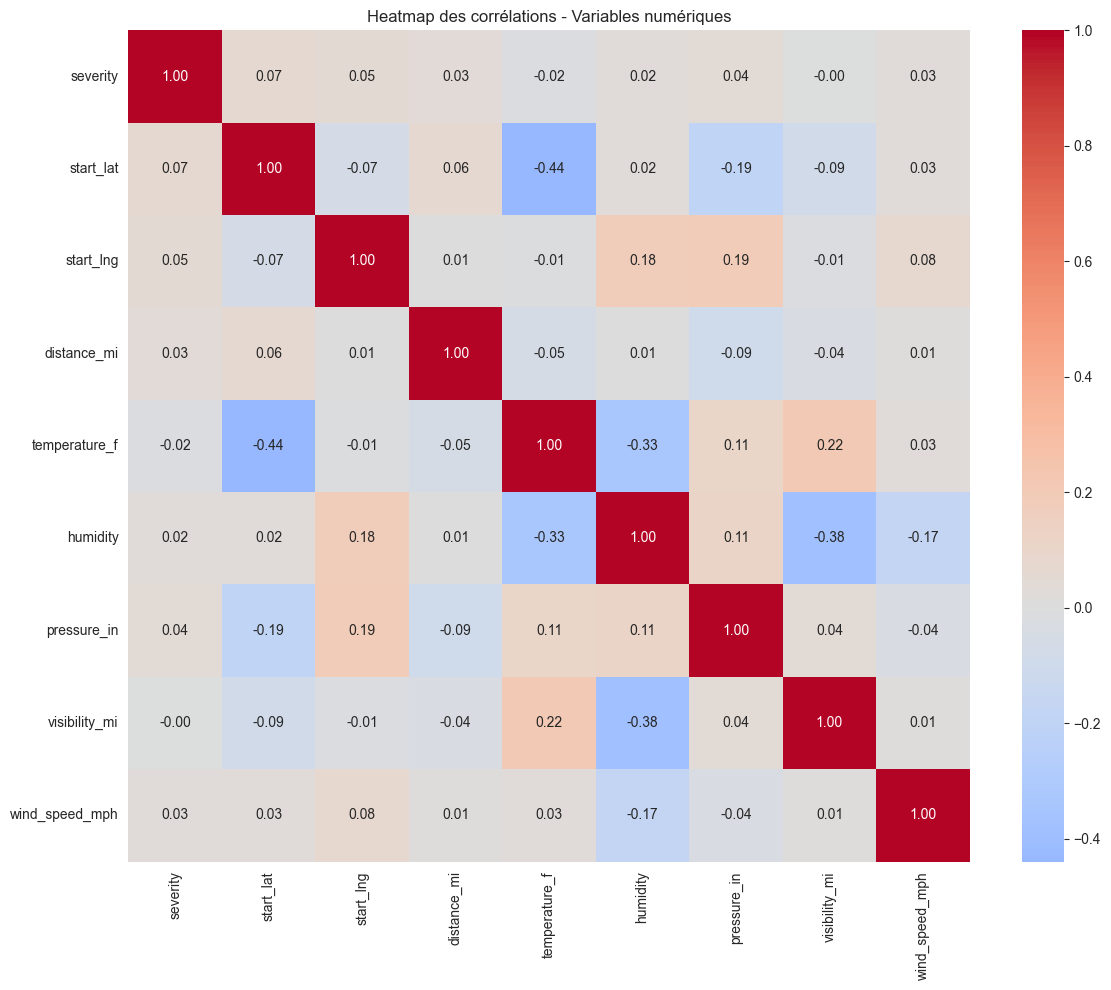

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histogramme de la durée des accidents
plt.figure(figsize=(8,4))

# Calculer la durée des accidents (en minutes)
df_duration = df.dropna(subset=['start_time', 'end_time'])
duration = (df_duration['end_time'] - df_duration['start_time']).dt.total_seconds() / 60

# Filtrer les durées raisonnables (< 24 heures = 1440 minutes)
duration_filtered = duration[(duration > 0) & (duration <= 1440)]

sns.histplot(duration_filtered, bins=50, kde=True)
plt.title('Distribution de la durée des accidents (minutes)')
plt.xlabel('Durée (min)')
plt.ylabel('Nombre d\'accidents')
plt.xlim(0, 120)
plt.show()

print(f"Durée moyenne: {duration_filtered.mean():.2f} minutes")
print(f"Durée médiane: {duration_filtered.median():.2f} minutes")

# Heatmap de corrélation 
plt.figure(figsize=(12,10))

numeric_cols = ['severity', 'start_lat', 'start_lng', 'distance_mi', 'temperature_f', 
                'humidity', 'pressure_in', 'visibility_mi', 'wind_speed_mph']
numeric_cols = [col for col in numeric_cols if col in df.columns]

corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt='.2f')
plt.title('Heatmap des corrélations - Variables numériques')
plt.tight_layout()
plt.show()

On remarque que la sévérité des accidents n'a pas de corrélation forte avec les autres variables numériques. 
cependant de facon plus globale, on voit que la temperature et correlé négativement à l'humidité et positivement à la visibilité à l'inverse de la temperature et la visibilté (qui sont positivement corrélé).
enfin on peut remarquer que la plupart des accidents ont une durée de moins de 60 minutes, avec une moyenne d'environ 105 minutes.

C:\Users\couta\AppData\Local\Temp\ipykernel_17928\1427651828.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_states.values, y=top_states.index, palette="viridis")


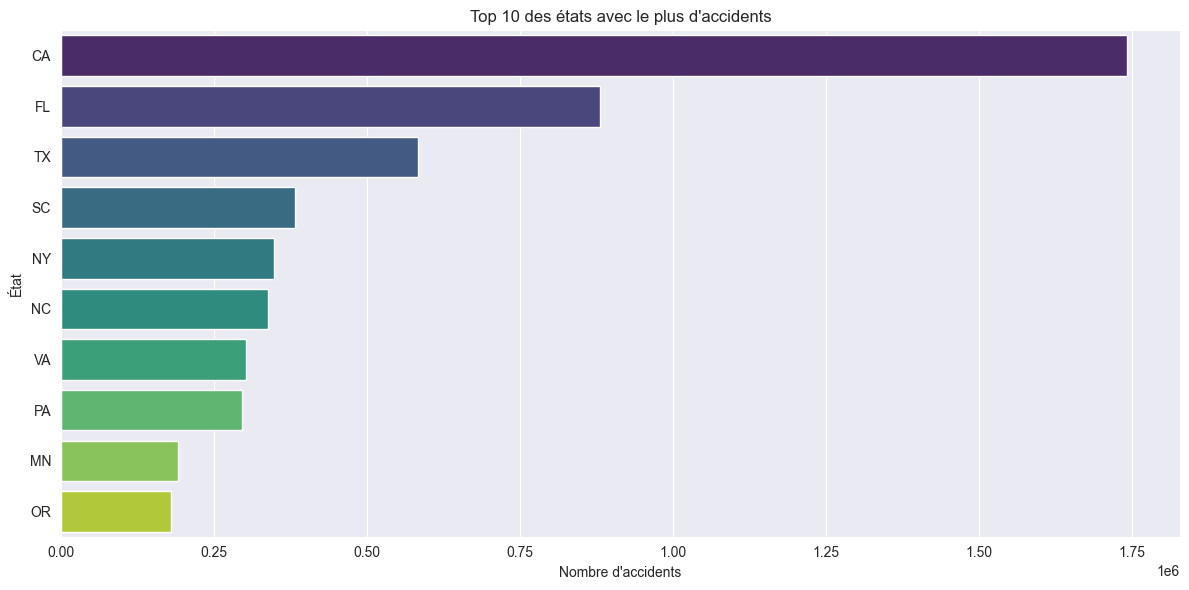

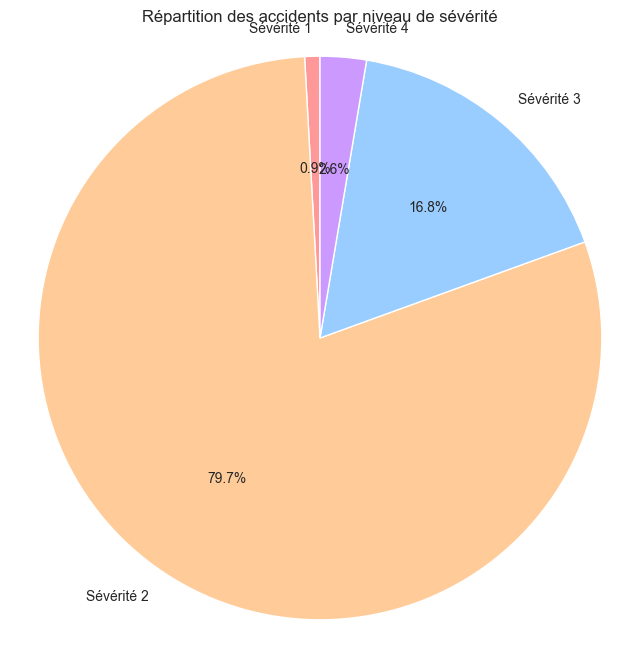

C:\Users\couta\AppData\Local\Temp\ipykernel_17928\1427651828.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weather_counts.values, y=weather_counts.index, palette="coolwarm")


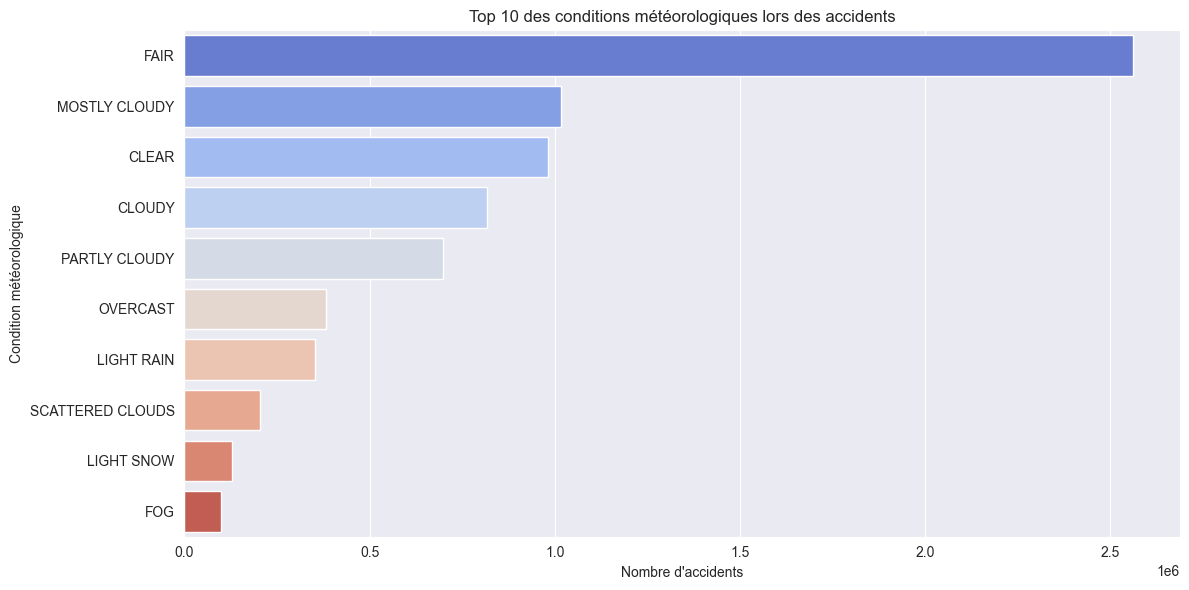

In [7]:
# Graphique en barres - Distribution par état (top 10)
plt.figure(figsize=(12, 6))
top_states = df['state'].value_counts().head(10)
sns.barplot(x=top_states.values, y=top_states.index, palette="viridis")
plt.title('Top 10 des états avec le plus d\'accidents')
plt.xlabel('Nombre d\'accidents')
plt.ylabel('État')
plt.tight_layout()
plt.show()

# Graphique en secteurs - Répartition par sévérité
plt.figure(figsize=(8, 8))
severity_counts = df['severity'].value_counts().sort_index()
colors = ['#ff9999','#ffcc99','#99ccff','#cc99ff']
plt.pie(severity_counts.values, labels=[f'Sévérité {i}' for i in severity_counts.index], 
        autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Répartition des accidents par niveau de sévérité')
plt.axis('equal')
plt.show()

# Analyse des conditions météorologiques
plt.figure(figsize=(12, 6))
weather_counts = df['weather_condition'].value_counts().head(10)
sns.barplot(x=weather_counts.values, y=weather_counts.index, palette="coolwarm")
plt.title('Top 10 des conditions météorologiques lors des accidents')
plt.xlabel('Nombre d\'accidents')
plt.ylabel('Condition météorologique')
plt.tight_layout()
plt.show()

On voit grace a ces visualisation que la plupart des accidents sont de sévérité 2 (80%) et 3 (17%), tandis que les sévérités 1 et 4 sont moins fréquentes (3% et 1% respectivement).
On remarque aussi que les états avec le plus d'accidents sont la Californie (CA), le Texas (TX) et la Floride (FL).
Enfin on remarque que la plupart des accidents se produisent par temps equilibré ou nuageux/trés nuageux (CLOUDY)

## 5. Machine Learning 
### 📌 Objectif :
Un pipeline de Machine Learning pour analyser des accidents de la route et :
- Prédire la sévérité d’un accident (classification ML)
- Identifier les zones à risque (clustering géographique)
- Détecter les hotspots (zones avec beaucoup d’accidents graves)
- Produire un rapport final avec métriques et visualisations

 MODÉLISATION AVANCÉE - PRÉDICTION DE SÉVÉRITÉ DES ACCIDENTS
 Dataset initial: 7,728,394 accidents

 PRÉPARATION DES FEATURES ML
----------------------------------------
 Features géographiques: 4 (['start_lat', 'start_lng', 'end_lat', 'end_lng'])
 Features météo: 5 (['temperature_f', 'humidity', 'pressure_in', 'visibility_mi', 'wind_speed_mph'])
 Features infrastructure: 13 (['amenity', 'bump', 'crossing', 'give_way', 'junction', 'no_exit', 'railway', 'roundabout', 'station', 'stop', 'traffic_calming', 'traffic_signal', 'turning_loop'])
 Features temporelles ajoutées: hour, day_of_week
  Encodé weather_condition: 144 classes
  Encodé wind_direction: 23 classes
  Encodé sunrise_sunset: 2 classes
 Total features ML: 28

 ENTRAÎNEMENT MODÈLES DE SÉVÉRITÉ
---------------------------------------------
 Échantillonnage: 50,000 samples pour l'entraînement
 Training: 40,000 | Test: 10,000

 Entraînement Random Forest...
 Accuracy: 0.807
 CV Score: 0.805 (±0.001)
 Temps: 13.26s

 Entraînement 

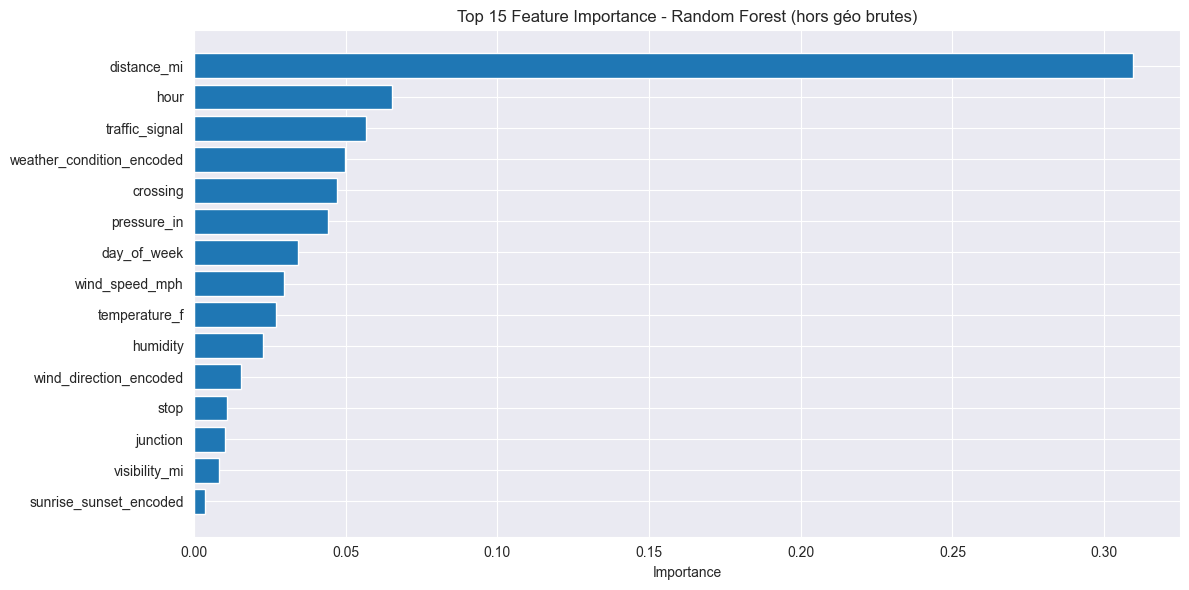


  CRÉATION DES ZONES À RISQUE
-----------------------------------
 Clustering sur 20,000 points avec 6 features
 Analyse des zones de risque:
           accident_count  avg_severity  center_lat  center_lng risk_level
risk_zone                                                                 
0                    2067         1.990      40.391     -80.898        LOW
1                    1363         3.193      40.586     -81.378       HIGH
2                    1332         2.075      39.752     -84.869     MEDIUM
3                    2297         1.990      37.322    -118.765        LOW
4                    1516         2.292      37.170     -96.390     MEDIUM
5                    2236         1.995      30.902     -86.042        LOW
6                    1041         3.083      31.726     -86.893       HIGH
7                    1913         1.994      40.369     -80.833        LOW
8                    1461         2.038      31.818     -97.875     MEDIUM
9                    1913       

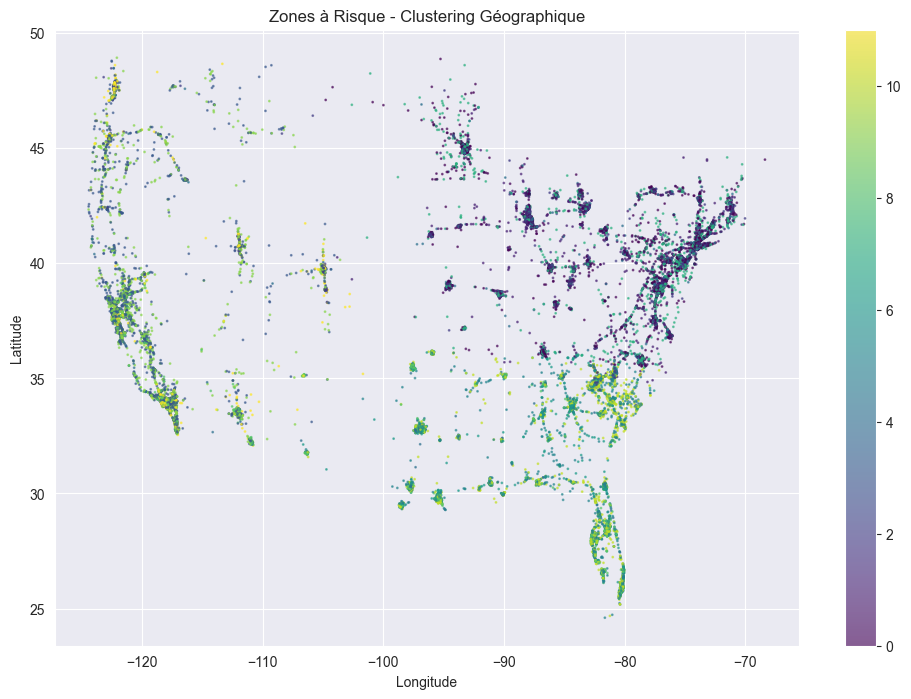


 CRÉATION DES HOTSPOTS GÉOGRAPHIQUES
----------------------------------------
 23182 hotspots identifiés

 Top 10 Hotspots:
       lat_grid  lng_grid  total_accidents  avg_severity  hotspot_score
62         25.9     -80.2            53223      2.163275       115136.0
6729       34.0    -118.2            39836      2.187167        87128.0
4686       32.8     -96.8            32693      2.256905        73785.0
21157      40.8     -73.9            31736      2.321496        73675.0
6524       33.9    -118.3            31719      2.255336        71537.0
6728       34.0    -118.3            31396      2.276755        71481.0
10700      35.8     -78.6            33268      2.099495        69846.0
38         25.7     -80.4            33737      2.008566        67763.0
9347       35.2     -80.8            33304      2.013812        67068.0
6918       34.1    -118.2            27995      2.209823        61864.0


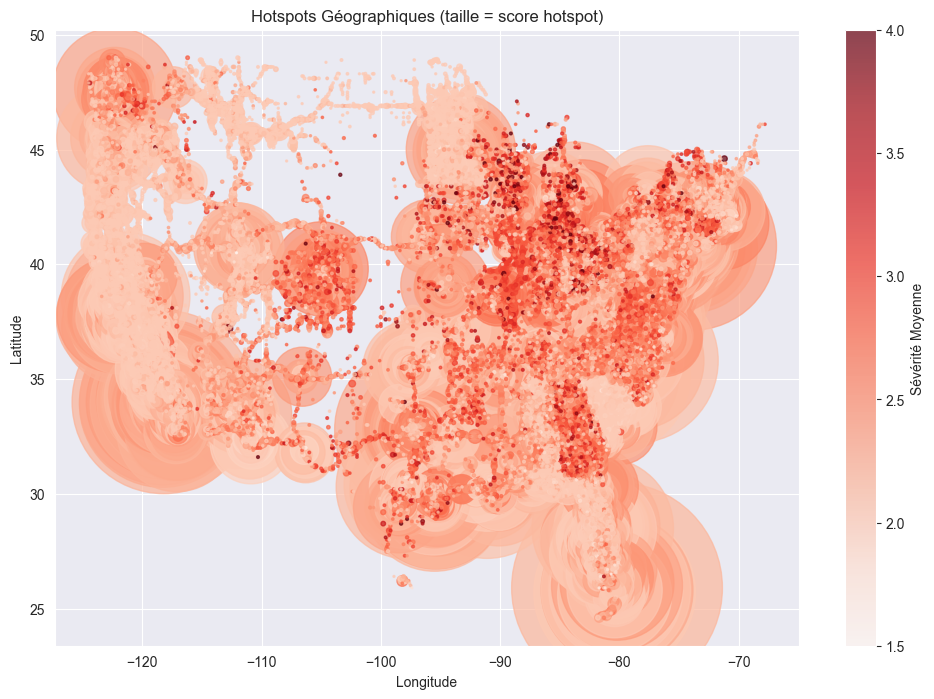


 RAPPORT FINAL - MODÉLISATION ML
 Meilleur modèle: Gradient Boosting
    Accuracy: 0.828
    CV Score: 0.825
  Zones à risque: 12 zones créées
    Zones HIGH risk: 3
 Hotspots: 23182 zones critiques
    Score max: 115136.0
 Modélisation terminée avec 7,728,394 accidents analysés

 Temps total d'exécution: 567.06 secondes


In [10]:
import time
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import numpy as np
import matplotlib.pyplot as plt


print(" MODÉLISATION AVANCÉE - PRÉDICTION DE SÉVÉRITÉ DES ACCIDENTS")
print("="*70)

class AccidentMLPipeline:
    def __init__(self, df):
        self.df = df.copy()
        self.results = {}
        self.models = {}
        print(f" Dataset initial: {len(self.df):,} accidents")
        
    def prepare_ml_features(self):
        print("\n PRÉPARATION DES FEATURES ML")
        print("-" * 40)
        
        # Features numériques géographiques
        numeric_features = ['start_lat', 'start_lng', 'end_lat', 'end_lng']
        
        # Features météorologiques
        weather_features = ['temperature_f', 'humidity', 'pressure_in', 
                           'visibility_mi', 'wind_speed_mph']
        
        # Features booléennes infrastructure 
        boolean_features = ['amenity', 'bump', 'crossing', 'give_way', 'junction', 
                           'no_exit', 'railway', 'roundabout', 'station', 'stop', 
                           'traffic_calming', 'traffic_signal', 'turning_loop']
        
        # Vérification
        available_numeric = [f for f in numeric_features if f in self.df.columns]
        available_weather = [f for f in weather_features if f in self.df.columns]
        available_boolean = [f for f in boolean_features if f in self.df.columns]
        
        print(f" Features géographiques: {len(available_numeric)} ({available_numeric})")
        print(f" Features météo: {len(available_weather)} ({available_weather})")
        print(f" Features infrastructure: {len(available_boolean)} ({available_boolean})")
        
        # Créer dataset ML
        ml_features = available_numeric + available_weather + available_boolean
        
        if 'distance_mi' in self.df.columns:
            ml_features.append('distance_mi')
        
        # Ajouter features temporelles 
        if 'start_time' in self.df.columns:
            self.df['hour'] = pd.to_datetime(self.df['start_time']).dt.hour
            self.df['day_of_week'] = pd.to_datetime(self.df['start_time']).dt.dayofweek
            ml_features.extend(['hour', 'day_of_week'])
            print(f" Features temporelles ajoutées: hour, day_of_week")
        
        # Encoder les variables catégorielles
        categorical_cols = ['weather_condition', 'wind_direction', 'sunrise_sunset']
        le_dict = {}
        
        for col in categorical_cols:
            if col in self.df.columns:
                le = LabelEncoder()
                self.df[f'{col}_encoded'] = le.fit_transform(self.df[col].astype(str))
                ml_features.append(f'{col}_encoded')
                le_dict[col] = le
                print(f"  Encodé {col}: {len(le.classes_)} classes")
        
        self.ml_features = [f for f in ml_features if f in self.df.columns]
        self.le_dict = le_dict
        
        print(f" Total features ML: {len(self.ml_features)}")
        return self.ml_features
    
    def train_severity_models(self):
        print("\n ENTRAÎNEMENT MODÈLES DE SÉVÉRITÉ")
        print("-" * 45)
        
        X = self.df[self.ml_features].fillna(0)
        y = self.df['severity']
        
        if len(X) > 50000:
            X_sample, _, y_sample, _ = train_test_split(X, y, train_size=50000, random_state=42, stratify=y)
            X, y = X_sample, y_sample
            print(f" Échantillonnage: {len(X):,} samples pour l'entraînement")
        
        # Split train/test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        print(f" Training: {len(X_train):,} | Test: {len(X_test):,}")
        
        # Standardisation pour certains modèles
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Modèles à tester
        models_config = {
            'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
            'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=6, random_state=42),
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
            'SVM': SVC(kernel='rbf', random_state=42)
        }
        
        results = {}
        
        for name, model in models_config.items():
            print(f"\n Entraînement {name}...")
            start_time = time.time()
            
            if name in ['Logistic Regression', 'SVM']:
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
                # Cross-validation
                cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=3)
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                # Cross-validation
                cv_scores = cross_val_score(model, X_train, y_train, cv=3)
            
            # Métriques
            accuracy = accuracy_score(y_test, y_pred)
            cv_mean = cv_scores.mean()
            duration = time.time() - start_time
            
            results[name] = {
                'accuracy': accuracy,
                'cv_score': cv_mean,
                'duration': duration,
                'predictions': y_pred
            }
            
            print(f" Accuracy: {accuracy:.3f}")
            print(f" CV Score: {cv_mean:.3f} (±{cv_scores.std()*2:.3f})")
            print(f" Temps: {duration:.2f}s")
            
            # Sauvegarder le meilleur modèle
            if name == 'Random Forest':
                self.models['best_severity'] = model
        
        self.results['severity_models'] = results
        self.X_test, self.y_test = X_test, y_test
        
        return results

    def analyze_feature_importance(self):
        if 'best_severity' not in self.models:
            return

        print("\n ANALYSE D'IMPORTANCE DES FEATURES")
        print("-" * 42)

        model = self.models['best_severity']
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            feature_importance = list(zip(self.ml_features, importances))

            excluded_features = {"start_lat", "start_lng", "end_lat", "end_lng"}

            feature_importance = [
                (f, imp) for f, imp in feature_importance if f not in excluded_features
            ]

            feature_importance.sort(key=lambda x: x[1], reverse=True)

            print(" Top 10 Features les plus importantes (hors géo brutes):")
            for i, (feature, importance) in enumerate(feature_importance[:10]):
                print(f"   {i+1:2d}. {feature:<20} : {importance:.4f}")

            plt.figure(figsize=(12, 6))
            features, importances = zip(*feature_importance[:15])
            plt.barh(range(len(features)), importances)
            plt.yticks(range(len(features)), features)
            plt.title('Top 15 Feature Importance - Random Forest (hors géo brutes)')
            plt.xlabel('Importance')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()

    def create_risk_zones(self):
        print("\n  CRÉATION DES ZONES À RISQUE")
        print("-" * 35)
        
        cluster_features = ['start_lat', 'start_lng', 'severity']
        
        if 'hour' in self.df.columns:
            cluster_features.append('hour')
        if 'junction' in self.df.columns:
            cluster_features.append('junction')
        if 'traffic_signal' in self.df.columns:
            cluster_features.append('traffic_signal')
        
        # Préparer données clustering
        cluster_data = self.df[cluster_features].fillna(0)
        
        if len(cluster_data) > 20000:
            cluster_data = cluster_data.sample(20000, random_state=42)
        
        print(f" Clustering sur {len(cluster_data):,} points avec {len(cluster_features)} features")
        
        scaler = StandardScaler()
        cluster_scaled = scaler.fit_transform(cluster_data)
        
        n_clusters = 12
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(cluster_scaled)
        
        # Analyser les clusters
        cluster_data['risk_zone'] = cluster_labels
        cluster_data['severity_orig'] = cluster_data['severity']
        
        risk_analysis = cluster_data.groupby('risk_zone').agg({
            'severity_orig': ['count', 'mean'],
            'start_lat': 'mean',
            'start_lng': 'mean'
        }).round(3)
        
        risk_analysis.columns = ['accident_count', 'avg_severity', 'center_lat', 'center_lng']
        risk_analysis['risk_level'] = pd.cut(
            risk_analysis['avg_severity'], 
            bins=[0, 2, 2.5, 4], 
            labels=['LOW', 'MEDIUM', 'HIGH']
        )
        
        print(" Analyse des zones de risque:")
        print(risk_analysis)
        
        
        self.results['risk_zones'] = risk_analysis
        
        # Visualisation
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(cluster_data['start_lng'], cluster_data['start_lat'], 
                            c=cluster_labels, cmap='viridis', alpha=0.6, s=1)
        plt.colorbar(scatter)
        plt.title('Zones à Risque - Clustering Géographique')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()
        
        return risk_analysis
    
    def create_hotspots(self):
        print("\n CRÉATION DES HOTSPOTS GÉOGRAPHIQUES")
        print("-" * 40)
        
        # Créer grille géographique
        df_hotspot = self.df.copy()
        df_hotspot['lat_grid'] = (df_hotspot['start_lat'] * 10).round() / 10  
        df_hotspot['lng_grid'] = (df_hotspot['start_lng'] * 10).round() / 10
        
        hotspots = df_hotspot.groupby(['lat_grid', 'lng_grid']).agg({
            'severity': ['count', 'mean']
        }).reset_index()
        
        hotspots.columns = ['lat_grid', 'lng_grid', 'total_accidents', 'avg_severity']
        
        # Filtrer minimum 5 accidents
        hotspots = hotspots[hotspots['total_accidents'] >= 5]
        
        # Score de hotspot
        hotspots['hotspot_score'] = hotspots['total_accidents'] * hotspots['avg_severity']
        hotspots = hotspots.sort_values('hotspot_score', ascending=False)
        
        print(f" {len(hotspots)} hotspots identifiés")
        print("\n Top 10 Hotspots:")
        print(hotspots.head(10)[['lat_grid', 'lng_grid', 'total_accidents', 'avg_severity', 'hotspot_score']])
        
        self.results['hotspots'] = hotspots
        
        # Visualisation
        plt.figure(figsize=(12, 8))
        plt.scatter(hotspots['lng_grid'], hotspots['lat_grid'], 
                   s=hotspots['hotspot_score']/5, c=hotspots['avg_severity'], 
                   cmap='Reds', alpha=0.7)
        plt.colorbar(label='Sévérité Moyenne')
        plt.title('Hotspots Géographiques (taille = score hotspot)')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()
        
        return hotspots
    
    def generate_final_report(self):
        print("\n" + "="*70)
        print(" RAPPORT FINAL - MODÉLISATION ML")
        print("="*70)
        
        # Meilleur modèle
        if 'severity_models' in self.results:
            best_model = max(self.results['severity_models'].items(), 
                           key=lambda x: x[1]['accuracy'])
            print(f" Meilleur modèle: {best_model[0]}")
            print(f"    Accuracy: {best_model[1]['accuracy']:.3f}")
            print(f"    CV Score: {best_model[1]['cv_score']:.3f}")
        
        # Zones de risque
        if 'risk_zones' in self.results:
            risk_zones = self.results['risk_zones']
            high_risk = len(risk_zones[risk_zones['risk_level'] == 'HIGH'])
            print(f"  Zones à risque: {len(risk_zones)} zones créées")
            print(f"    Zones HIGH risk: {high_risk}")
        
        # Hotspots
        if 'hotspots' in self.results:
            hotspots = self.results['hotspots']
            print(f" Hotspots: {len(hotspots)} zones critiques")
            if len(hotspots) > 0:
                max_score = hotspots['hotspot_score'].max()
                print(f"    Score max: {max_score:.1f}")
        
        print(f" Modélisation terminée avec {len(self.df):,} accidents analysés")

# Lancement du pipeline ML
start_time = time.time()
ml_pipeline = AccidentMLPipeline(df)

# Étapes du pipeline
features = ml_pipeline.prepare_ml_features()
severity_results = ml_pipeline.train_severity_models()
ml_pipeline.analyze_feature_importance()
risk_zones = ml_pipeline.create_risk_zones()
hotspots = ml_pipeline.create_hotspots()
ml_pipeline.generate_final_report()

duration = time.time() - start_time
print(f"\n Temps total d'exécution: {duration:.2f} secondes")

grace à ces visualisations on remarque que les variables les plus importantes pour prédire la sévérité des accidents sont :
- distance_mi
- l'heure de la journée (hour)
- les signaux de trafic (traffic_signal)

On remarque aussi que les variables les zones a riques ce situe principalement dans les zones urbaines (grandes villes) ainsi que sur les cotes et principales dans le sud des états unis.

## 6. Tableau de mesures
### 📌 Objectif :
Comparer les performances des modèles testés.

| Modèle               | Exactitude | CV-Score  |
|----------------------|------------|-----------|
| Logistic Regression  | 0.796      |   0.797   |
| Random Forest        | 0.807      |   0.805   |
| Gradiant Boosting    | 0.828      |   0.825   |
| SVM                  | 0.797      |   0.797   |

Ainsi on remarque grace a ce tableau que le modèle de Gradient Boosting est le plus performant avec une exactitude de 82.8% et un CV-Score de 82.5%.
A l'inverse le modèle de logistic Regression est le moins performant avec une exactitude de 79.6% et un CV-Score de 79.7%.


## 7.API
### 📌 Objectif

- Construire une API sécurisée et interactive qui expose les données d’accidents (contenues dans un DataFrame df) à travers plusieurs endpoints, avec :
- Authentification JWT (connexion avec utilisateur/mot de passe).
- Pagination des résultats pour gérer de gros volumes.
- Routes d’analyse (par état, météo, ville, temps, hotspots).
- Simple dashboard interactif avec Dash/Plotly (en complément du PowerBI).

In [ ]:
# API FastAPI utilisant directement le DataFrame df
from fastapi import FastAPI, HTTPException, Depends, Query
from fastapi.security import HTTPBearer, HTTPAuthorizationCredentials
from pydantic import BaseModel
from typing import List, Optional
import jwt
import hashlib
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import math
import dash
from dash import dcc, html
from fastapi.middleware.wsgi import WSGIMiddleware
import plotly.express as px

# Configuration
SECRET_KEY = "accident-api-secret-key"
ALGORITHM = "HS256"

# FastAPI avec Swagger auto
app = FastAPI(
    title="Accident Analysis API",
    description="API securisee avec pagination pour l'analyse des accidents",
    version="1.0.0",
    docs_url="/docs",
    redoc_url="/redoc"
)

security = HTTPBearer()

# Models
class UserLogin(BaseModel):
    username: str
    password: str

    class Config:
        schema_extra = {
            "example": {
                "username": "admin",
                "password": "admin"
            }
        }

class Token(BaseModel):
    access_token: str
    token_type: str

class PaginatedResponse(BaseModel):
    data: List[dict]
    page: int
    size: int
    total_pages: int
    total_items: int

# Utilisateurs
USERS = {
    "admin": "8c6976e5b5410415bde908bd4dee15dfb167a9c873fc4bb8a81f6f2ab448a918",  # admin
    "user": "04f8996da763b7a969b1028ee3007569eaf3a635486ddab211d512c85b9df8fb"   # user123
}

def verify_user(username: str, password: str) -> bool:
    """Verifie utilisateur"""
    hashed = hashlib.sha256(password.encode()).hexdigest()
    return USERS.get(username) == hashed

def create_token(username: str) -> str:
    """Cree token JWT"""
    payload = {
        "sub": username,
        "exp": datetime.utcnow() + timedelta(hours=1)
    }
    return jwt.encode(payload, SECRET_KEY, algorithm=ALGORITHM)

def verify_token(credentials: HTTPAuthorizationCredentials = Depends(security)) -> str:
    """Verifie token"""
    try:
        payload = jwt.decode(credentials.credentials, SECRET_KEY, algorithms=[ALGORITHM])
        username = payload.get("sub")
        if not username:
            raise HTTPException(status_code=401, detail="Token invalide")
        return username
    except:
        raise HTTPException(status_code=401, detail="Token invalide")

def paginate_dataframe(data: List[dict], page: int, size: int) -> dict:
    """Pagination pour les donnees du DataFrame"""
    total_items = len(data)
    total_pages = math.ceil(total_items / size)

    start_idx = (page - 1) * size
    end_idx = start_idx + size

    paginated_data = data[start_idx:end_idx]

    return {
        "data": paginated_data,
        "page": page,
        "size": size,
        "total_pages": total_pages,
        "total_items": total_items
    }

# Fonctions d'analyse utilisant le DataFrame df

def get_state_stats():
    """Statistiques par state"""
    stats = df.groupby('state').agg({
        'id': 'count',
        'severity': 'mean',
        'city': 'nunique'
    }).reset_index()
    stats.columns = ['state', 'total_accidents', 'avg_severity', 'cities_count']
    stats['avg_severity'] = stats['avg_severity'].round(2)
    stats = stats.sort_values('total_accidents', ascending=False)
    return stats.to_dict('records')

def get_weather_stats():
    """Analyse meteorologique """
    weather_stats = df.groupby('weather_condition').agg({
        'id': 'count',
        'severity': 'mean',
        'temperature_f': 'mean'
    }).reset_index()
    weather_stats.columns = ['weather_condition', 'total_accidents', 'avg_severity', 'avg_temperature']
    weather_stats['avg_severity'] = weather_stats['avg_severity'].round(2)
    weather_stats['avg_temperature'] = weather_stats['avg_temperature'].round(1)
    weather_stats = weather_stats.sort_values('total_accidents', ascending=False)
    return weather_stats.to_dict('records')

def get_city_stats(state_filter=None):
    """Hotspots des villes """
    city_df = df.copy()
    if state_filter:
        city_df = city_df[city_df['state'] == state_filter.upper()]

    city_stats = city_df.groupby(['state', 'city']).agg({
        'id': 'count',
        'severity': 'mean',
        'start_lat': 'mean',
        'start_lng': 'mean'
    }).reset_index()
    city_stats.columns = ['state', 'city', 'total_accidents', 'avg_severity', 'latitude', 'longitude']
    city_stats['avg_severity'] = city_stats['avg_severity'].round(2)
    city_stats['latitude'] = city_stats['latitude'].round(4)
    city_stats['longitude'] = city_stats['longitude'].round(4)
    city_stats = city_stats.sort_values('total_accidents', ascending=False)
    return city_stats.to_dict('records')

def get_time_patterns():
    """Patterns temporels """
    if 'start_time' not in df.columns:
        return []

    time_df = df.copy()
    time_df['hour'] = pd.to_datetime(time_df['start_time']).dt.hour
    time_df['day_of_week'] = pd.to_datetime(time_df['start_time']).dt.dayofweek

    time_stats = time_df.groupby(['hour', 'day_of_week']).agg({
        'id': 'count',
        'severity': 'mean'
    }).reset_index()
    time_stats.columns = ['hour', 'day_of_week', 'total_accidents', 'avg_severity']
    time_stats['avg_severity'] = time_stats['avg_severity'].round(2)
    time_stats = time_stats.sort_values('total_accidents', ascending=False)
    return time_stats.to_dict('records')

def get_hotspots():
    """Hotspots geographiques """
    hotspot_df = df.copy()
    hotspot_df['lat_grid'] = (hotspot_df['start_lat'] * 10).round() / 10
    hotspot_df['lng_grid'] = (hotspot_df['start_lng'] * 10).round() / 10

    hotspots = hotspot_df.groupby(['lat_grid', 'lng_grid']).agg({
        'id': 'count',
        'severity': 'mean'
    }).reset_index()
    hotspots.columns = ['lat_grid', 'lng_grid', 'total_accidents', 'avg_severity']
    hotspots = hotspots[hotspots['total_accidents'] >= 5]  # Minimum 5 accidents
    hotspots['hotspot_score'] = hotspots['total_accidents'] * hotspots['avg_severity']
    hotspots['avg_severity'] = hotspots['avg_severity'].round(2)
    hotspots['hotspot_score'] = hotspots['hotspot_score'].round(2)
    hotspots = hotspots.sort_values('hotspot_score', ascending=False)
    return hotspots.to_dict('records')

# Routes

@app.get("/", tags=["Info"])
async def root():
    """Page d'accueil de l'API"""
    return {
        "message": "Accident Analysis API",
        "version": "1.0.0",
        "swagger": "/docs",
        "dashboard": "/dashboard",
        "login_endpoint": "/auth/login",
        "example_users": {
            "admin": "admin",
            "user": "user123"
        },
        "data_source": f"DataFrame avec {len(df):,} accidents"
    }

@app.post("/auth/login", response_model=Token, tags=["Authentification"])
async def login(user: UserLogin):

    if not verify_user(user.username, user.password):
        raise HTTPException(status_code=401, detail="Identifiants incorrects")

    token = create_token(user.username)
    return {"access_token": token, "token_type": "bearer"}
@app.get("/api/states", response_model=PaginatedResponse, tags=["Donnees"])
async def get_states(
        page: int = Query(1, ge=1, description="Numero de page"),
        size: int = Query(10, ge=1, le=100, description="Taille de page"),
        current_user: str = Depends(verify_token)
):

    try:
        data = get_state_stats()
        return paginate_dataframe(data, page, size)
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

@app.get("/api/weather", response_model=PaginatedResponse, tags=["Donnees"])
async def get_weather(
        page: int = Query(1, ge=1, description="Numero de page"),
        size: int = Query(10, ge=1, le=50, description="Taille de page"),
        current_user: str = Depends(verify_token)
):

    try:
        data = get_weather_stats()
        return paginate_dataframe(data, page, size)
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

@app.get("/api/cities", response_model=PaginatedResponse, tags=["Donnees"])
async def get_cities(
        page: int = Query(1, ge=1, description="Numero de page"),
        size: int = Query(20, ge=1, le=100, description="Taille de page"),
        state: Optional[str] = Query(None, description="Filtrer par etat (ex: CA)"),
        current_user: str = Depends(verify_token)
):

    try:
        data = get_city_stats(state)
        return paginate_dataframe(data, page, size)
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

@app.get("/api/time", response_model=PaginatedResponse, tags=["Donnees"])
async def get_time_patterns(
        page: int = Query(1, ge=1, description="Numero de page"),
        size: int = Query(24, ge=1, le=50, description="Taille de page"),
        current_user: str = Depends(verify_token)
):

    try:
        data = get_time_patterns()
        return paginate_dataframe(data, page, size)
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

@app.get("/api/hotspots", response_model=PaginatedResponse, tags=["Donnees"])
async def get_hotspots_api(
        page: int = Query(1, ge=1, description="Numero de page"),
        size: int = Query(10, ge=1, le=50, description="Taille de page"),
        current_user: str = Depends(verify_token)
):

    try:
        data = get_hotspots()
        return paginate_dataframe(data, page, size)
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

@app.get("/api/summary", tags=["Statistiques"])
async def get_summary(current_user: str = Depends(verify_token)):

    try:
        total_accidents = len(df)
        total_states = df['state'].nunique()
        total_cities = df['city'].nunique() if 'city' in df.columns else 0
        avg_severity = df['severity'].mean()

        top_state = df['state'].value_counts().index[0]
        top_state_accidents = df['state'].value_counts().iloc[0]

        top_weather = df['weather_condition'].value_counts().index[0]

        return {
            "total_accidents": int(total_accidents),
            "total_states": int(total_states),
            "total_cities": int(total_cities),
            "avg_severity": round(float(avg_severity), 2),
            "top_state": top_state,
            "top_state_accidents": int(top_state_accidents),
            "top_weather_condition": top_weather,
            "user": current_user,
            "timestamp": datetime.utcnow(),
            "data_period": {
                "start": str(df['start_time'].min()) if 'start_time' in df.columns else "N/A",
                "end": str(df['start_time'].max()) if 'start_time' in df.columns else "N/A"
            }
        }

    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

dash_app = dash.Dash(
    __name__,
    requests_pathname_prefix="/dashboard/",
    suppress_callback_exceptions=True
)
state_df = pd.DataFrame(get_state_stats())
weather_df = pd.DataFrame(get_weather_stats())

fig_states = px.bar(
    state_df.head(10),
    x="state",
    y="total_accidents",
    title="Top 10 États par nombre d'accidents"
)

fig_weather = px.bar(
    weather_df.head(10),
    x="weather_condition",
    y="total_accidents",
    title="Top 10 Conditions météo"
)

severity_counts = df['severity'].value_counts().sort_index().reset_index()
severity_counts.columns = ['severity', 'count']
fig_severity = px.bar(
    severity_counts,
    x='severity',
    y='count',
    title="Répartition des accidents par sévérité"
)

dash_app.layout = html.Div([
    html.H1("🚗 Dashboard Accidents"),
    html.Div([
        dcc.Graph(figure=fig_states),
        dcc.Graph(figure=fig_weather),
        dcc.Graph(figure=fig_severity),
    ])
])
app.mount("/dashboard", WSGIMiddleware(dash_app.server))

print("API FastAPI configuree avec le DataFrame df")
print(f"DataFrame contient {len(df):,} accidents")
print("Endpoints disponibles:")
print("- POST /auth/login")
print("- GET /api/states")
print("- GET /api/weather")
print("- GET /api/cities")
print("- GET /api/time")
print("- GET /api/hotspots")
print("- GET /api/summary")
print("- GET /docs (Swagger UI)")

import nest_asyncio
nest_asyncio.apply()

import uvicorn
uvicorn.run(app, host="127.0.0.1", port=8000)

C:\SDK\Python\3.12\Lib\site-packages\pydantic\_internal\_config.py:373: UserWarning:

Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'



API FastAPI configuree avec le DataFrame df
DataFrame contient 7,728,394 accidents
Endpoints disponibles:
- POST /auth/login
- GET /api/states
- GET /api/weather
- GET /api/cities
- GET /api/time
- GET /api/hotspots
- GET /api/summary
- GET /docs (Swagger UI)


INFO:     Started server process [3824]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:57770 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:57770 - "GET /_dash-layout HTTP/1.1" 200 OK
INFO:     127.0.0.1:57771 - "GET /_dash-dependencies HTTP/1.1" 200 OK
INFO:     127.0.0.1:57772 - "GET /_favicon.ico?v=4.0.0rc1 HTTP/1.1" 200 OK
INFO:     127.0.0.1:57772 - "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 Not Modified
INFO:     127.0.0.1:57771 - "GET /_dash-component-suites/plotly/package_data/plotly.min.js HTTP/1.1" 304 Not Modified
INFO:     127.0.0.1:57781 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:57782 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:57794 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:57794 - "GET /_dash-layout HTTP/1.1" 200 OK
INFO:     127.0.0.1:57795 - "GET /_dash-dependencies HTTP/1.1" 200 OK
INFO:     127.0.0.1:57795 - "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 Not Modified
INFO:     127.0.0.1:57794 - "GET /_dash-component-suites/plotly/package_data/plotly.min.js HTTP/1.1" 304 Not Modifi

## 📋 Bilan des contributions de l'équipe 
 
- **Saad** : Préparation et nettoyage des données, gestion des valeurs manquantes.
- **Thomas Y** : Analyse exploratoire, visualisations statistiques.
- **Thomas C** : Modélisation ML, comparaison des modèles.
- **Noam** : Coordination, intégration du notebook, synthèse des résultats.
 
Chacun a contribué à la progression du projet lors de cette journée de hackathon.
 